Intalling all the necessary libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import nltk
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the dataset and displaying it

In [ ]:
path="/content/drive/MyDrive/ML_Project/IMDBDataset.csv"
df = pd.read_csv(path) #read the csv file (IMDB Movie review DATSET)
print(df)              #display the data of csv file

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:
df.shape     #to analyse the data
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


checking the number of samples in each class

In [ ]:
df0=df[df['sentiment']== 'positive'] #counting no. of samples in positive class
df1=df[df['sentiment'] == 'negative'] ##counting no. of samples in negative class
df0.shape[0], df1.shape[0]

(25000, 25000)

Lots of reviews have common words like(a, the, of....) which contributes less to the training. So detecting them

In [ ]:
#to count the most common used words
def get_corpus(data):
    corpus = []
    for i in data:
        for j in i.split():
            corpus.append(j.strip())
    return corpus
corpus = get_corpus(df.review)
corpus[:5]

count = Counter(corpus) #counting the repeated values in corpus
most_words = count.most_common(10) 
most_common = pd.DataFrame(most_words,columns=["words","count_"])

most_common= most_common.sort_values('count_') #sorting the count values
most_common

,words,count_
9,this,113726
8,that,126818
7,I,132498
6,in,169981
5,is,203056
4,to,261850
3,of,283625
2,and,301919
1,a,306960
0,the,568735


Checking if there are any empty rows if any the could create error while training

In [ ]:
total_null = df.isnull().sum().sort_values(ascending = False) #checking if there any empty rows in the .csv file
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
print("Total records = ", df.shape[0])

missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent']) #calcuating the percentage if there any empty cell
missing_data

Total records =  50000


,Total Missing,In Percent
review,0,0.0
sentiment,0,0.0


In [ ]:
df0=df[df['sentiment']== 'positive'] #separating the positive reviews
df1=df[df['sentiment'] == 'negative'] #separating the negative reviews
df0.shape, df1.shape
df=pd.concat([df0,df1],axis=0) #joining them back
df = df.sample(frac = 1)
df.shape

(50000, 2)

Doing some preprocessing to the text by panda

In [ ]:
df['review'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)  #Remove Hashtags
df['review'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True) #Remove Mention
df['review'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True) #Remove URL
df['review']=df['review'].str.lower() #to lowercase

In [ ]:
stop = stopwords.words('english') #defining stopwords (commonly used words)
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #removing stopwords

In [ ]:
def punctuations_removal(text): #function to remove puntuation mark
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text

df['review'] = df['review'].apply(lambda x: punctuations_removal(x))

In [ ]:
stemmer = PorterStemmer()
def stem_sentence(sentence): #function to do stemming (transform words to its root form, removing suffixes prefixes etc)
    words = nltk.word_tokenize(sentence.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop]
    stemmed_sentence = " ".join(stemmed_words)
    return stemmed_sentence
df["review"] = df["review"].apply(stem_sentence)

In [ ]:
label_encoder = preprocessing.LabelEncoder() #labeling the preprocessed data 
df['sentiment']= label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
37915,seen film 20 year impact rememb sit credit sev...,1
46589,wow rememb mani aw film loos revolv around hig...,0
41374,well even rate movi one even cinemat valu real...,0
23207,1979 film music hair loos base infam 1960 's b...,1
14669,came outer space ii good film good cast includ...,1


Dividing the data to input and output

In [ ]:
y = df['sentiment'] #dividing the data into  output column
x = df['review'] #dividing the data into input column

The ML models cannot take input directly as strings so we have to convert them into numeric values. The process is called vectorization.

In [ ]:
corpus = []       #vectorization for reviews
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])
    
vectorizer1 = TfidfVectorizer(max_features=1000)
X1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = X1.todense().tolist()
df = pd.DataFrame(denselist1, columns=feature_names1)

In [ ]:
corpus = [] #vectorization for output labels
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])
    
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
denselist = X.todense().tolist()
train = pd.DataFrame(denselist, columns=feature_names)

Defining and trainig five different model and noting their accuracy

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(df, y, test_size=0.2, random_state=0) # splitting the training and testing part from the data

accuracy = {'TF-IDF':[]} # For creating a table of the accuracies in the end


regressor_LL_tf = LinearRegression() # Linear Regression model defining
regressor_LL_tf.fit(X_temp, y_temp)
y_predict_LL_tf = regressor_LL_tf.predict(X_test)
a=(regressor_LL_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)


regressor_LR_tf = LogisticRegression(C=1.0,penalty='l2',solver='newton-cg') # Logistic Regression model defining
regressor_LR_tf.fit(X_temp, y_temp)
y_predict_LR_tf = regressor_LR_tf.predict(X_test)
a=(regressor_LR_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)


model_DT_tf = DecisionTreeClassifier(criterion = 'gini', max_depth=2)  # Decision tree model defining
model_DT_tf.fit(X_temp, y_temp)
y_predict_DT_tf = model_DT_tf.predict(X_test)
a=(model_DT_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)


model_RF_tf = RandomForestClassifier(n_estimators= 100, max_features = 'log2') #Random Forest model defining
model_RF_tf.fit(X_temp, y_temp)
y_predict_RF_tf = model_RF_tf.predict(X_test)
a=(model_RF_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

model_KN_tf = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 5, weights= 'distance')  # K-Neighbors Classifier model defining
model_KN_tf.fit(X_temp, y_temp)
y_predict_KN_tf = model_KN_tf.predict(X_test)
a=(model_KN_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)


model = ['Linear','Logistic','DT','RF','KN'] #Evaluating the models
data = {'model':model,'accuracy':accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)

In [ ]:
compare_models #comparing the models

,model,accuracy
0,Linear,0.54253
1,Logistic,0.86760
2,DT,0.65040
3,RF,0.84540
4,KN,0.61330


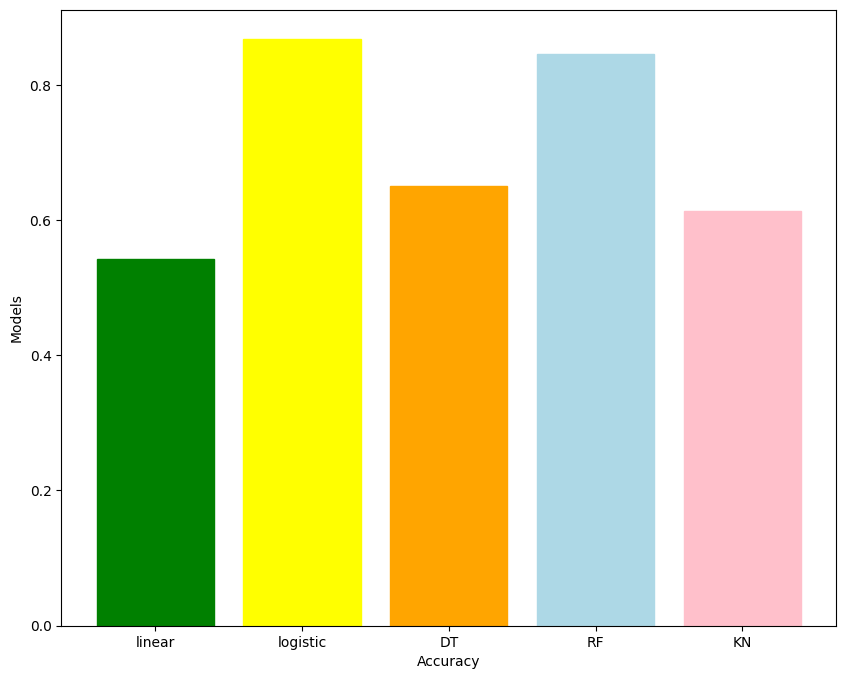

In [ ]:
compare_models["accuracy"].tolist()         #plotting the accuracy values
model = ['linear','logistic','DT','RF','KN']
acc = compare_models["accuracy"].tolist()
plt.figure(figsize=(10,8))
graph = plt.bar(model,acc)
plt.xlabel('Accuracy')
plt.ylabel('Models')    
graph[0].set_color('green')
graph[1].set_color('yellow')
graph[2].set_color('orange')
graph[3].set_color('lightblue')
graph[4].set_color('pink')

As the accuracy value of logistic regression is high we will go for logistic regression. Time to tune the parameters

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],         #choosing the parameters for high accuracy, we go for logistic regression
    'penalty': ['l2']
}
log = LogisticRegression(random_state=42, solver='liblinear')
grid_search = GridSearchCV(estimator=log, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_temp, y_temp)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10], 'penalty': ['l2']})

In [ ]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Best hyperparameters:  {'C': 1, 'penalty': 'l2'}
Best accuracy:  0.8633


In [ ]:
lr = LogisticRegression(C=1,penalty='l2') #we apply the parameter which gives the best accuracy
lr.fit(X_temp, y_temp)

# Predict sentiment labels for testing data
y_pred = lr.predict(X_test)

# Evaluate performance of model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.8676
Precision: 0.8524492234169654
Recall: 0.880139802631579
F1 Score: 0.8660732348776047


Checking if the trained model works properly.

In [ ]:
#Our model is ready in the name of lr
#lets try an example

input_sentence1 = "This movie was good! I love the acting and the plot."
input_sentence2 = "This movie was bad! I hate the acting and the plot."


In [ ]:
input_sentence = "This movie was good! I love the acting and the plot."

In [ ]:
def pre_process(input_sentence):
  words = word_tokenize(input_sentence)
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in words if not word.lower() in stop_words]
  filtered_sentence = ' '.join(filtered_words)
  pr=punctuations_removal(filtered_sentence)
  sts=stem_sentence(pr)
  input_numeric = vectorizer1.transform([sts])
  return input_numeric



In [ ]:
#we have to pre-process the sententence before feeding to the model
words = word_tokenize(input_sentence)
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if not word.lower() in stop_words]
filtered_sentence = ' '.join(filtered_words)
pr=punctuations_removal(filtered_sentence)
sts=stem_sentence(pr)

input_numeric = vectorizer1.transform([sts])

In [ ]:
print(lr.predict(input_numeric))

[1]


In [ ]:
numeric1=pre_process(input_sentence1)
numeric2=pre_process(input_sentence2)

In [ ]:
predicted_sentiment1 = lr.predict(numeric1) # Predict sentiment label for the input data using the trained model
print("prediction of sentence1",predicted_sentiment1) # Print the predicted sentiment label
predicted_sentiment2 = lr.predict(numeric2) # Predict sentiment label for the input data using the trained model
print("prediction of sentence2",predicted_sentiment2) # Print the predicted sentiment label

prediction of sentence1 [1]
prediction of sentence2 [0]


the input sentence 1 was positive and our model predicted it as 1(positive) which is correct and the input sentence two was negative and our model predicted it as 0 (negative) which is correct. This shows our model works properly.

Installing tesseract ocr to detect text

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 2s (2,937 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

Now we will read the image and extract the text and check the sentiment

In [ ]:
import cv2
from google.colab.patches import cv2_imshow 

reading the image

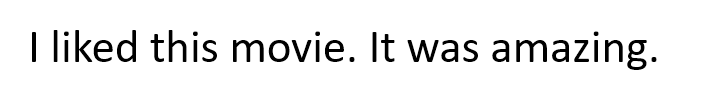

In [ ]:
image=cv2.imread("/content/drive/MyDrive/ML_Project/sample.png")
cv2_imshow(image)

extracting the text

In [ ]:
img =cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # Convert the image to grayscale

text = pytesseract.image_to_string(img) # Use pytesseract to read the text from the image

print(text)

| liked this movie. It was amazing.



predicting

In [ ]:
numeric4=pre_process(text)
print(lr.predict(numeric4))

[1]


Repeating the above steps for a negative review image.

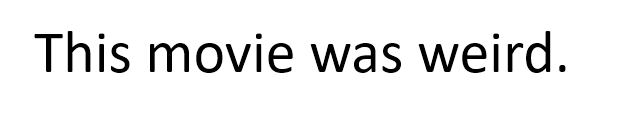

In [ ]:
image2=cv2.imread("/content/drive/MyDrive/ML_Project/sample2.png")
cv2_imshow(image2)

In [ ]:
img2 =cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)    # Convert the image to grayscale

text2 = pytesseract.image_to_string(img2) # Use pytesseract to read the text from the image

print(text2)

This movie was weird.



In [ ]:
numeric5=pre_process(text2)
print(lr.predict(numeric5))

[0]


In [ ]:
#References
#1. https://www.kaggle.com/code/gautamkumar93069/imdb-dataset-eda-sentimental-analysis
#2. https://www.tutorialspoint.com/natural_language_toolkit/index.htm  (for use of nltk libraries)
#3.src="https://www.statology.org/pandas-fillna-with-mean/"  
#4.src="https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html"
#5.src="https://www.geeksforgeeks.org/matplotlib-pyplot-semilogx-in-python/"
#6.https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html (for neural networks)
#7.src="#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html"
#8.https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c (for feature extraction function)
#9.https://stackoverflow.com/questions/69782208/read-an-image-from-google-drive-using-python-in-colab (for reading images from google drive)
#10.src="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html"
#11.src="https://www.statology.org/k-fold-cross-validation-in-python/" 
#12.src="https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/" 
#13.src="https://numpy.org/doc/stable/reference/generated/numpy.logspace.html"